In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [4]:
#construction de la matrice M d'un element triangle 
def matrice_locale(element, coordinates): 
    M = np.zeros((3, 3));
    [x1,y1] = coordinates[element[0]];
    [x2,y2] = coordinates[element[1]];
    [x3,y3] = coordinates[element[2]];
    x = [x1, x2, x3];
    y = [y1, y2, y3];
    alpha = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1);
    
    for i in range(3):
        jacob_i = np.array( [ [y[(i+1)%3]-y[(i+2)%3]] , [x[(i+2)%3]-x[(i+1)%3]]] );
        for j in range(3):
            jacob_j = np.array( [ [y[(j+1)%3]-y[(j+2)%3]] , [x[(j+2)%3]-x[(j+1)%3]]] );
            M[i,j] = (1/(2*alpha)) *(np.transpose(jacob_i).dot(jacob_j));
            
    
    return M

In [5]:
#assemblage de la matrice A à partir des triangles
def assemblerA(elements3, coordinates):              
    n = len(coordinates);
    A = np.zeros((n,n));
    for i in range(len(elements3)):
        M = matrice_locale(elements3[i,:], coordinates); 
        for l in range(3):
            for j in range(3):
                A[elements3[i,l], elements3[i,j]] += M[l,j];
                
    return A

In [71]:
#Tester 
coordinates, elements3,dirichlet, neumann = maillage(3);
A = assemblerA(elements3, coordinates);
print(A)


[[ 1.  -0.5  0.  -0.5  0.   0.   0.   0.   0. ]
 [-0.5  2.  -0.5  0.  -1.   0.   0.   0.   0. ]
 [ 0.  -0.5  1.   0.   0.  -0.5  0.   0.   0. ]
 [-0.5  0.   0.   2.  -1.   0.  -0.5  0.   0. ]
 [ 0.  -1.   0.  -1.   4.  -1.   0.  -1.   0. ]
 [ 0.   0.  -0.5  0.  -1.   2.   0.   0.  -0.5]
 [ 0.   0.   0.  -0.5  0.   0.   1.  -0.5  0. ]
 [ 0.   0.   0.   0.  -1.   0.  -0.5  2.  -0.5]
 [ 0.   0.   0.   0.   0.  -0.5  0.  -0.5  1. ]]


In [105]:
def ud(x,y): 
    return 1

In [106]:
def f(x,y):
    #return 2*((math.pi)**2)*math.sin(np.pi*x)*math.sin(np.pi*y)       #pour la partie compléments d'analyse
    return 1

In [107]:
#Calcul du second membre
def second_membre(elements3, coordinates, A, dirichlet, ud):
    b = np.zeros((len(A),1));   
    for i in range(len(elements3)):
        sommets = elements3[i,:];
        [x1,y1] = coordinates[sommets[0]];
        [x2,y2] = coordinates[sommets[1]];
        [x3,y3] = coordinates[sommets[2]];
        x = [x1, x2, x3];
        y = [y1, y2, y3];
        alpha = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1);
        xG = (x1+x2+x3)/3 ;
        yG = (y1+y2+y3)/3 ; 
        
        for j in range(3):
            b[sommets[j]] = b[sommets[j]] + (alpha/6)*f(xG, yG);
        
    for l in range(len(coordinates)):
        for k in range(len(coordinates)):
            if (k in dirichlet):
                b[l] = b[l] - ud(coordinates[k,0], coordinates[k,1])*A[l,k];
    
    return b


In [108]:
#Tester 
coordinates, elements3,dirichlet, neumann = maillage(3);
A = assemblerA(elements3, coordinates);
b = second_membre(elements3, coordinates, A, dirichlet, ud);

print(b)

[[ 0.04166667]
 [-0.875     ]
 [ 0.08333333]
 [-0.875     ]
 [ 4.25      ]
 [-0.875     ]
 [ 0.08333333]
 [-0.875     ]
 [ 0.04166667]]


In [111]:

def solution_T(A,b, dirichlet) :
    
    #degrés de liberté

    i = 0
    b1 = np.zeros((len(b))-len(dirichlet))
    for k in range(len(b)):
        if k not in dirichlet:
            b1[i] = b[k] 
            i += 1

    i = 0
    A1 = np.zeros((len(A)-len(dirichlet),len(A)))
    for k in range(len(A)):
        if k not in dirichlet:
            A1[i,:] = A[k,:] 
            i += 1

    i = 0
    A2 = np.zeros((len(A1),len(A)-len(dirichlet)))
    for k in range(len(A1[0])):
        if k not in dirichlet:
            A2[:,i] = A1[:,k] 
            i += 1



    #resoudre le problème
    u1 = ssl.spsolve(A2,b1)


    i = 0
    u = np.zeros((len(b)))
    for k in range(len(b)):
        if k  in dirichlet:
            u[k] = 1

        else :
            u[k] = u1[i]
            i+=1
            
    return u, A2




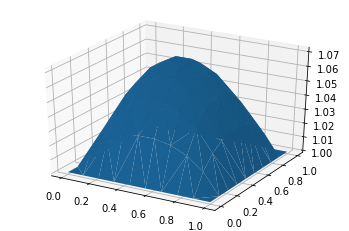

In [112]:
#Affichage de la solution :

coordinates, elements3,dirichlet, neumann = maillage(10);
A = assemblerA(elements3, coordinates);
b = second_membre(elements3, coordinates, A, dirichlet, ud);
u,A2 = solution_T(A,b, dirichlet);
show(coordinates,u)



**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [113]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [114]:
def matrice_locale_Q(q,coordinates):
    M = np.zeros((4,4))
    [x1,y1] = coordinates[q[0]]
    [x2,y2] = coordinates[q[1]]
    [x3,y3] = coordinates[q[2]]
    [x4,y4] = coordinates[q[3]]
    
    det_J = (x2-x1)*(y4-y1)-(x4-x1)*(y2-y1)
    J = np.array([[x2-x1 , x4-x1],[y2-y1,y4-y1]])
    B = np.linalg.inv(J.T*J)
    a = B[0,0]
    b = B[0,1]
    c = B[1,1]
    
    
    M[0,0] = 2 * a + 3 *b + 2*c;
    M[0,1] = -2*a + c;
    M[0,2] = - a  - 3*b - c;
    M[0,3] = a - 2*c;
    M[1,1] = 2*a-3*b + 2*c;
    M[1,2] = a - 2 *c;
    M[1,3] = -a + 3*b - c;
    M[2,2] = 2 * a + 3 *b + 2*c;
    M[2,3] = -2*a + c;
    M[3,3] = 2 * a - 3 *b + 2*c;
    M = M.T + M - np.diag(M)*np.eye(4,4)
     
    M = (det_J/6)*M
            
    return M

In [115]:
#assemblage de la matrice A à partir des quadrangles et triangles
def assemblerA_Mixte(elements3, elements4, coordinates):              
    n = len(coordinates);
    A = np.zeros((n,n));
    
    for i in range(len(elements3)):
        M = matrice_locale(elements3[i,:], coordinates); 
        for l in range(3):
            for j in range(3):
                A[elements3[i,l], elements3[i,j]] += M[l,j];
                
    for i in range(len(elements4)):
        M_q = matrice_locale_Q(elements4[i,:], coordinates); 
        for l in range(4):
            for j in range(4):
                A[elements4[i,l], elements4[i,j]] += M_q[l,j];
                
    return A

In [116]:
#Tester 
A = assemblerA_Mixte(e3,e4,ccs);
print(np.linalg.eigvals(A))

[4.39621277e+00 3.45400908e+00 3.18279953e+00 2.80029931e+00
 2.67255682e+00 4.26789901e-16 2.21858492e+00 3.98975029e-01
 4.39832944e-01 5.97543136e-01 1.72075762e+00 9.10396085e-01
 9.67205157e-01 1.12271628e+00 1.44900398e+00 1.39580039e+00]


In [117]:
def ud(x,y) : 
    return 1

In [118]:
def f(x,y) : 
    return 1

In [119]:
def g(x,y) :
    return 1

In [120]:
#Calcul du second membre
def second_membre_mixte(elements3, elements4, coordinates, A, dirichlet, neumann, ud):
    b = np.zeros((len(A),1));   
    
#Conditions de Dirichlet

    #Triangle
    for i in range(len(elements3)):
        sommets = elements3[i,:];
        [x1,y1] = coordinates[sommets[0]];
        [x2,y2] = coordinates[sommets[1]];
        [x3,y3] = coordinates[sommets[2]];
        x = [x1, x2, x3];
        y = [y1, y2, y3];
        alpha = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1);
        xG = (x1+x2+x3)/3 ;
        yG = (y1+y2+y3)/3 ; 
        
        for j in range(3):
            b[sommets[j]] = b[sommets[j]] + (alpha/6)*f(xG, yG);
          
    #Quadrangle
    for i in range(len(elements4)):
        sommets = elements4[i,:];
        [x1,y1] = coordinates[sommets[0]];
        [x2,y2] = coordinates[sommets[1]];
        [x3,y3] = coordinates[sommets[2]];
        [x4,y4] = coordinates[sommets[3]];
        x = [x1, x2, x3, x4];
        y = [y1, y2, y3, y4];
        alpha = (x2-x1)*(y4-y1) - (x4-x1)*(y2-y1);
        xG = (x1+x2+x3+x4)/4 ;
        yG = (y1+y2+y3+y4)/4 ; 
        
        for j in range(4):
            b[sommets[j]] = b[sommets[j]] + (alpha/4)*f(xG, yG);
            
        
    for l in range(len(coordinates)):
        for k in range(len(coordinates)):
            if (k in dirichlet):
                b[l] = b[l] - ud(coordinates[k,0], coordinates[k,1])*A[l,k];
    
    
#Conditions de Neumann    
    
    for i in range(len(neumann)) :
        arrete = neumann[i,:];
        [x0,y0] = coordinates[arrete[0]];
        [x1, y1] = coordinates[arrete[1]];
        b[arrete] = b[arrete] + (1/2)*math.sqrt(( (x0-x1)**2 + (y0-y1)**2 ))*g((x0+x1)/2, (y0+y1)/2) 
            
        
    return b


In [121]:
A = assemblerA_Mixte(e3,e4,ccs);
b = second_membre_mixte(e3, e4, ccs, A, dds, nns, ud);
print(b)

[[-0.30555556]
 [ 1.63888889]
 [-1.67777778]
 [ 2.11685185]
 [-1.69356874]
 [ 1.65116133]
 [-0.30555556]
 [-0.94444444]
 [-0.61111111]
 [-0.30555556]
 [-0.61111111]
 [-0.94444444]
 [ 1.31296296]
 [ 1.77777778]
 [ 1.31777778]
 [-0.35296296]]


In [122]:
def solution_mixte(A, b, dds):

    
    #degrés de liberté

    i = 0
    b1 = np.zeros((len(b))-len(dds))    
    for k in range(len(b)):                #parcours du second membre
        if k not in dds:
            b1[i] = b[k] 
            i += 1

    i = 0
    A1 = np.zeros((len(A)-len(dds),len(A)))  
    for k in range(len(A)):                #parcours des lignes de A
        if k not in dds:
            A1[i,:] = A[k,:] 
            i += 1

    i = 0
    A2 = np.zeros((len(A1),len(A)-len(dds)))
    for k in range(len(A1[0])):             #parcours des colonnes de A
        if k not in dds:
            A2[:,i] = A1[:,k] 
            i += 1



    #résolution du système
    u1 = ssl.spsolve(A2,b1)


    i = 0
    u = np.zeros((len(b)))
    for k in range(len(b)):
        if k  in dds:
            u[k] = 1

        else :
            u[k] = u1[i]
            i+=1

    return u



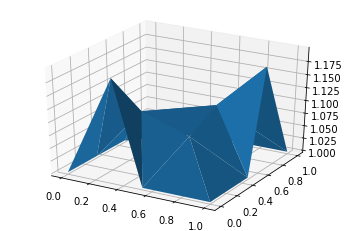

In [123]:
#Affichage de la solution :

A = assemblerA_Mixte(e3,e4,ccs);
b = second_membre_mixte(e3, e4, ccs, A, dds, nns, ud);
u = solution_mixte(A, b, dds);
show(ccs,u);



In [91]:
#Compléments d'analyse du système

In [92]:
#Solution exacte 

def u_ex(coordinates) :
    u = np.zeros((len(coordinates)))
    for i in range (len(coordinates)):
        u[i] = math.sin(np.pi*coordinates[i,0])*math.sin(np.pi*coordinates[i,1])
    return u


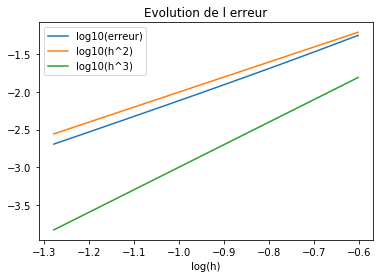

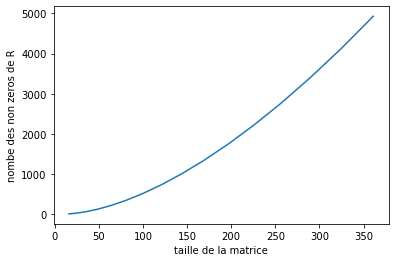

In [104]:
#Calcul de l'erreur et du nombre de non zeros 

n = 20;    #nombre maximale des éléments du maillage
erreur = np.zeros((n));
h = np.zeros((n));
nnz = np.zeros((n));
taille_matrice = np.zeros((n));


for i in range (4,n):
    
    #Solution par discrétisation
    coordinates, elements3,dirichlet, neumann = maillage(i);
    A = assemblerA(elements3, coordinates);
    b = second_membre(elements3, coordinates, A, dirichlet, ud);
    u, A2 = solution_T(A, b, dirichlet);
    
    #solution exacte
    uex = u_ex(coordinates);      

    #Calcul de l'erreur
    h[i] = math.sqrt(1/len(u));
    erreur[i] = (h[i])*np.linalg.norm(uex-u);
    
    #Calcul du nombre des non zeros
    R = np.linalg.cholesky(A2);
    nnz[i] = np.count_nonzero(R);
    taille_matrice[i] = i**2;
    
    
    
    
plt.plot(np.log10(h[4:n]),np.log10(erreur[4:n]), label='log10(erreur)');
plt.xlabel('log(h)');
plt.plot(np.log10(h[4:n]),np.log10(h[4:n]**2), label='log10(h^2)');
plt.plot(np.log10(h[4:n]),np.log10(h[4:n]**3), label='log10(h^3)');
plt.legend();
plt.title('Evolution de l erreur');
plt.show();

plt.plot(taille_matrice[4:n], nnz[4:n]);
plt.xlabel('taille de la matrice');
plt.ylabel('nombe des non zeros de R');
plt.show();




